In [2]:
import os
from nilearn import plotting
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import nilearn.plotting as niplot
from nilearn.masking import apply_mask
from scipy.ndimage import center_of_mass
from nilearn.image import mean_img
from scipy.ndimage import label
import pandas as pd

homedir = "/Users/jan/Documents/example data/"
# homedir = '/home/gusia/Desktop/BrainHack/brainhack_env/example_data/'

In [11]:
!pwd

/Users/jan/Documents/example data


In [3]:
os.chdir(homedir)

In [4]:
def calculate_center_of_mass(voxel_data):
    """Compute the center of mass for a 3D voxel array."""
    # Create grid indices (voxel coordinates)
    z, y, x = np.indices(voxel_data.shape)
    
    # Total intensity (sum of all voxel values)
    total_intensity = np.sum(voxel_data)
    
    # Compute weighted average for each axis
    com_x = np.sum(x * voxel_data) / total_intensity
    com_y = np.sum(y * voxel_data) / total_intensity
    com_z = np.sum(z * voxel_data) / total_intensity
    
    return (com_x, com_y, com_z)

In [12]:
def load_masks_and_data():
    # Load fMRI (4D) and brain mask (3D)
    fmri_img = nib.load("smoothed.nii")
    mask_img = nib.load("BrainHack_ocular_fMRI/eye_niftii/graymattermask_resampled.nii.gz")
    eyemask_img = nib.load("BrainHack_ocular_fMRI/eye_niftii/nau_mask_resampled.nii.gz")
    
    mask_data = mask_img.get_fdata().astype(bool)
    eyemask_data = eyemask_img.get_fdata().astype(bool)
    
    fmri_data_4d = fmri_img.get_fdata()
    n_timepoints = fmri_data_4d.shape[3]
    
    return fmri_img, fmri_data_4d, mask_data, eyemask_data, n_timepoints

In [6]:
# def make_mask(fmri_data_4d, mask_data, eyemask_data, n_timepoints):
#     for t in range(n_timepoints):
#         # Extract data from one time point 
#         fmri_volume = fmri_data_4d[..., t]  # Choose volume t
        
#         # Apply mask to fMRI
#         brain_only = fmri_volume * mask_data
#         eyes_only = fmri_volume * eyemask_data
        
#         # Distinguish the eyes
#         without_gm = eyes_only - brain_only
#         without_gm_img = nib.Nifti1Image(without_gm, affine=fmri_img.affine)
        
#         # Mask the region of interest
#         eyes_roi = without_gm
        
#     return eyes_roi

In [7]:
def get_top_brightest_voxels(eyes_roi, top_percent=0.01):
    flat_eyes_roi = eyes_roi.ravel()
    nonzero_indices = np.flatnonzero(flat_eyes_roi)
    top_n = int(len(nonzero_indices) * top_percent)

    # Get top n brightest voxel indices within the ROI
    flat_indices = np.argpartition(flat_eyes_roi, -top_n)[-top_n:]
    sorted_flat_indices = flat_indices[np.argsort(flat_eyes_roi[flat_indices])[::-1]]
    brightest_coords = np.array(np.unravel_index(sorted_flat_indices, eyes_roi.shape)).T

    # Create empty image to store the brightest voxels
    brightest_voxels_img = np.zeros_like(eyes_roi)

    # Set the intensity values at those coordinates
    for x, y, z in brightest_coords:
        brightest_voxels_img[x, y, z] = eyes_roi[x, y, z]
    
    return brightest_voxels_img

In [8]:
def find_largest_components(brightest_voxels_img, fmri_volume, affine):
    from scipy.ndimage import label
    import nibabel as nib

    # Label connected components (regions of adjacent bright voxels)
    labeled, num_labels = label(brightest_voxels_img)

    # Find the size of each connected component (cluster)
    component_sizes = np.bincount(labeled.ravel())

    # Ignore background (label 0), sort components by size
    sorted_indices = np.argsort(component_sizes[1:])[::-1]
    largest_label = sorted_indices[0] + 1
    second_label = sorted_indices[1] + 1

    # Create binary masks
    largest_component = labeled == largest_label
    second_component = labeled == second_label

    # Create separate images for each cluster
    largest_img = np.zeros_like(fmri_volume)
    largest_img[largest_component] = fmri_volume[largest_component]
    
    second_img = np.zeros_like(fmri_volume)
    second_img[second_component] = fmri_volume[second_component]

    # Wrap to NIfTI
    largest_nii = nib.Nifti1Image(largest_img, affine)
    second_nii = nib.Nifti1Image(second_img, affine)

    # Convert to world coordinates
    largest_coords = np.column_stack(np.where(largest_component))
    second_coords = np.column_stack(np.where(second_component))

    largest_world = affine.dot(np.column_stack((largest_coords, np.ones(len(largest_coords)))).T).T[:, :3]
    second_world = affine.dot(np.column_stack((second_coords, np.ones(len(second_coords)))).T).T[:, :3]

    # Determine left/right by X-coordinate (left = negative)
    if largest_world[0][0] < 0:
        left_eye_img = largest_nii
        right_eye_img = second_nii
    else:
        left_eye_img = second_nii
        right_eye_img = largest_nii

    return left_eye_img, right_eye_img

In [9]:
def mask_time_com_bright(fmri_img, fmri_data_4d, mask_data, eyemask_data, n_timepoints):
    affine = fmri_img.affine

    left_eye_time = np.empty(n_timepoints, dtype='object')
    right_eye_time = np.empty(n_timepoints, dtype='object')
    left_center = np.zeros((n_timepoints, 3), dtype=float)
    right_center = np.zeros((n_timepoints, 3), dtype=float)
    left_center_bright = np.zeros((n_timepoints, 3), dtype=float)
    right_center_bright = np.zeros((n_timepoints, 3), dtype=float)

    for t in range(n_timepoints):
        fmri_volume = fmri_data_4d[..., t]
        brain_only = fmri_volume * mask_data
        eyes_only = fmri_volume * eyemask_data
        without_gm = eyes_only - brain_only

        brightest_voxels_img = get_top_brightest_voxels(without_gm)
        
        # Use the known affine
        left_eye_img, right_eye_img = find_largest_components(
            brightest_voxels_img, fmri_volume, affine
        )

        left_data = left_eye_img.get_fdata()
        right_data = right_eye_img.get_fdata()

        # Use your own center of mass function
        com_l = calculate_center_of_mass(left_data)
        com_r = calculate_center_of_mass(right_data)

        # Get brightest voxel
        bright_l = np.unravel_index(np.argmax(left_data), left_data.shape)
        bright_r = np.unravel_index(np.argmax(right_data), right_data.shape)

        # Store results
        left_center[t] = com_l
        right_center[t] = com_r
        left_center_bright[t] = bright_l
        right_center_bright[t] = bright_r
        left_eye_time[t] = left_eye_img
        right_eye_time[t] = right_eye_img

        print(f" Time point {t+1}/{n_timepoints} done.")

    return left_center, right_center, left_center_bright, right_center_bright


In [13]:
fmri_img, fmri_data_4d, mask_data, eyemask_data, n_timepoints = load_masks_and_data()

left_center, right_center, left_center_bright, right_center_bright = mask_time_com_bright(
    fmri_img, fmri_data_4d, mask_data, eyemask_data, n_timepoints
)

 Time point 1/128 done.
 Time point 2/128 done.
 Time point 3/128 done.
 Time point 4/128 done.
 Time point 5/128 done.
 Time point 6/128 done.
 Time point 7/128 done.
 Time point 8/128 done.
 Time point 9/128 done.
 Time point 10/128 done.
 Time point 11/128 done.
 Time point 12/128 done.
 Time point 13/128 done.
 Time point 14/128 done.
 Time point 15/128 done.
 Time point 16/128 done.
 Time point 17/128 done.
 Time point 18/128 done.
 Time point 19/128 done.
 Time point 20/128 done.
 Time point 21/128 done.
 Time point 22/128 done.
 Time point 23/128 done.
 Time point 24/128 done.
 Time point 25/128 done.
 Time point 26/128 done.
 Time point 27/128 done.
 Time point 28/128 done.
 Time point 29/128 done.
 Time point 30/128 done.
 Time point 31/128 done.
 Time point 32/128 done.
 Time point 33/128 done.
 Time point 34/128 done.
 Time point 35/128 done.
 Time point 36/128 done.
 Time point 37/128 done.
 Time point 38/128 done.
 Time point 39/128 done.
 Time point 40/128 done.
 Time poi

In [14]:
from scipy.stats import zscore
import pandas as pd

def remove_outliers_zscore(df, coord_cols, threshold=3, output_csv=None):
    """
    Removes rows from a DataFrame where any specified coordinate column
    has a z-score above the threshold.

    Args:
        df (pd.DataFrame): The input DataFrame.
        coord_cols (list): List of column names to compute z-scores on.
        threshold (float): Z-score threshold for outlier detection.
        output_csv (str or None): If provided, path to save the cleaned DataFrame as CSV.

    Returns:
        df_cleaned (pd.DataFrame): DataFrame with outliers removed.
    """
    z_scores = np.abs(zscore(df[coord_cols], nan_policy='omit'))
    mask = (z_scores < threshold).all(axis=1)
    df_cleaned = df[mask].reset_index(drop=True)

    if output_csv:
        df_cleaned.to_csv(output_csv, index=False)
        print(f" Saved cleaned DataFrame to {output_csv}")

    removed = len(df) - len(df_cleaned)
    print(f"Removed {removed} outlier(s) based on z-score threshold = {threshold}")

    return df_cleaned

In [15]:
def calculate_eye_correlations(df, prefix_left='left', prefix_right='right'):
    """
    Calculates Pearson correlation coefficients between left and right eye coordinates.

    Args:
        df (pd.DataFrame): DataFrame containing left/right x, y, z voxel columns.
        prefix_left (str): Prefix for left eye column names.
        prefix_right (str): Prefix for right eye column names.

    Returns:
        dict: Dictionary with keys 'x', 'y', 'z' and correlation values.
    """
    cor_x = df[['x_left_voxel', 'x_right_voxel']].corr().iloc[0, 1]
    cor_y = df[['y_left_voxel', 'y_right_voxel']].corr().iloc[0, 1]
    cor_z = df[['z_left_voxel', 'z_right_voxel']].corr().iloc[0, 1]

    return {'x': cor_x, 'y': cor_y, 'z': cor_z}

In [16]:
# Create DataFrame - CSV file - CENTRE OF MASS

df_centers = pd.DataFrame({
    'timepoint': np.arange(len(left_center)),
    'x_left_voxel': left_center[:, 0],
    'y_left_voxel': left_center[:, 1],
    'z_left_voxel': left_center[:, 2],
    'x_right_voxel': right_center[:, 0],
    'y_right_voxel': right_center[:, 1],
    'z_right_voxel': right_center[:, 2],
})

# Save to CSV
df_centers.to_csv("centre_of_mass_corrected_eye_voxels.csv", index=False)

print("Saved to centre_of_mass_corrected_eye_voxels.csv")

Saved to centre_of_mass_corrected_eye_voxels.csv


In [17]:
# Create DataFrame - BRIGHTEST VOXELS
df_brightest = pd.DataFrame({
    'timepoint': np.arange(len(left_center_bright)),
    'x_left_voxel': left_center_bright[:, 0],
    'y_left_voxel': left_center_bright[:, 1],
    'z_left_voxel': left_center_bright[:, 2],
    'x_right_voxel': right_center_bright[:, 0],
    'y_right_voxel': right_center_bright[:, 1],
    'z_right_voxel': right_center_bright[:, 2],
})

df_brightest.to_csv("brightest_voxels_eye_positions.csv", index=False)
print("Saved to brightest_voxels_eye_positions.csv")

Saved to brightest_voxels_eye_positions.csv


In [18]:
coord_columns = [
    'x_left_voxel', 'y_left_voxel', 'z_left_voxel',
    'x_right_voxel', 'y_right_voxel', 'z_right_voxel'
]

df_cleaned_com = remove_outliers_zscore(
    df=df_centers,
    coord_cols=coord_columns,
    threshold=3,
    output_csv="df_cleaned_com.csv"
)

# df_cleaned_brightness = remove_outliers_zscore(
#     df=df_brightest,
#     coord_cols=coord_columns,
#     threshold=3,
#     output_csv="df_cleaned_brightness.csv"
# )

 Saved cleaned DataFrame to df_cleaned_com.csv
Removed 7 outlier(s) based on z-score threshold = 3


In [19]:
correlations_com = calculate_eye_correlations(df_cleaned_com)
print("Center of Mass Correlations:", correlations_com)

correlations_bright = calculate_eye_correlations(df_cleaned_brightness)
print("Brightest Voxel Correlations:", correlations_bright)

Center of Mass Correlations: {'x': 0.666377433633032, 'y': 0.5182411533745415, 'z': 0.17256136724066048}


NameError: name 'df_cleaned_brightness' is not defined

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_eye_correlations(df, title="Eye Coordinate Correlations", save_path=None):
    """
    Plots scatterplots with regression lines for left vs. right eye voxel coordinates (x, y, z).
    
    Args:
        df (pd.DataFrame): DataFrame with columns x/y/z_left_voxel and x/y/z_right_voxel
        title (str): Plot title
        save_path (str or None): If provided, saves the plot to this path
    """
    
    sns.set(style="whitegrid", font_scale=1.2)
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Calculate correlations
    cor_x = df[['x_left_voxel', 'x_right_voxel']].corr().iloc[0, 1]
    cor_y = df[['y_left_voxel', 'y_right_voxel']].corr().iloc[0, 1]
    cor_z = df[['z_left_voxel', 'z_right_voxel']].corr().iloc[0, 1]

    # X-axis plot
    sns.regplot(
        data=df, x='x_left_voxel', y='x_right_voxel',
        ax=axs[0], color='skyblue', line_kws={'color': 'black'}
    )
    axs[0].set_title(f"X Correlation: r = {cor_x:.2f}")
    axs[0].set_xlabel("Left Eye X")
    axs[0].set_ylabel("Right Eye X")

    # Y-axis plot
    sns.regplot(
        data=df, x='y_left_voxel', y='y_right_voxel',
        ax=axs[1], color='orange', line_kws={'color': 'black'}
    )
    axs[1].set_title(f"Y Correlation: r = {cor_y:.2f}")
    axs[1].set_xlabel("Left Eye Y")
    axs[1].set_ylabel("Right Eye Y")

    # Z-axis plot
    sns.regplot(
        data=df, x='z_left_voxel', y='z_right_voxel',
        ax=axs[2], color='lightgreen', line_kws={'color': 'black'}
    )
    axs[2].set_title(f"Z Correlation: r = {cor_z:.2f}")
    axs[2].set_xlabel("Left Eye Z")
    axs[2].set_ylabel("Right Eye Z")

    plt.suptitle(title, fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Plot saved to {save_path}")

    plt.show()

Plot saved to com_eye_correlation_plot.png


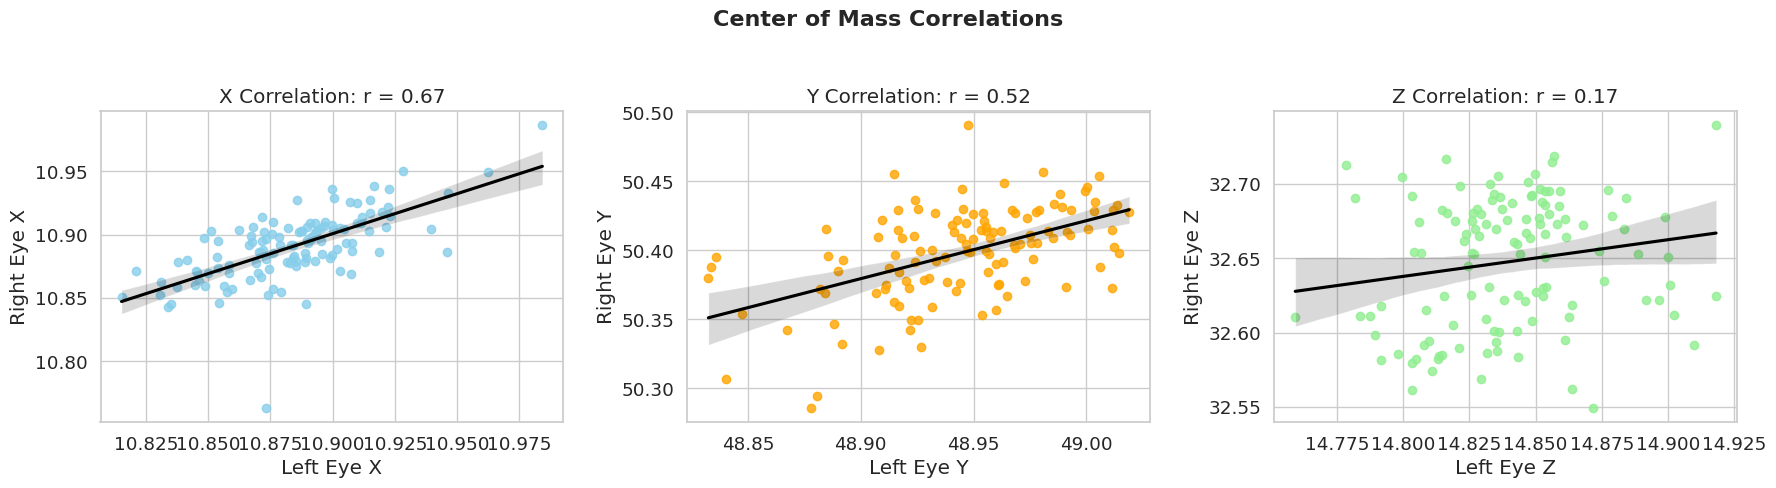

Plot saved to brightest_eye_correlation_plot.png


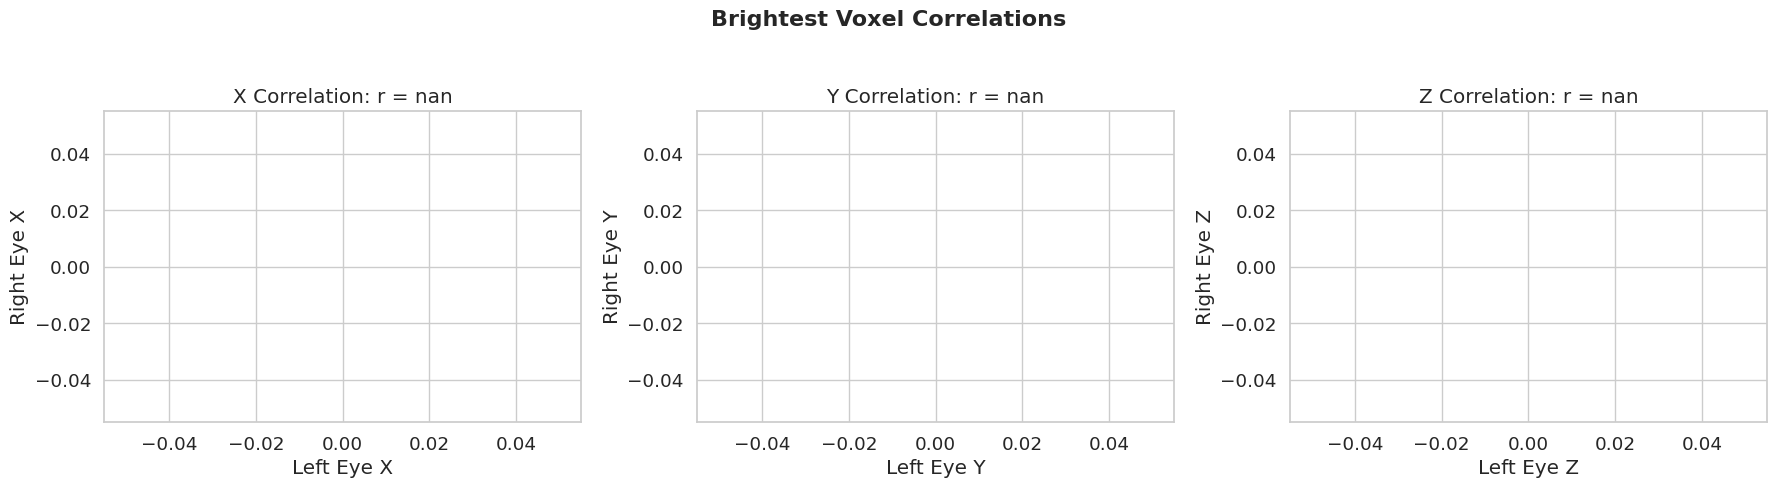

In [78]:
plot_eye_correlations(df_cleaned_com, title="Center of Mass Correlations", save_path="com_eye_correlation_plot.png")

plot_eye_correlations(df_cleaned_brightness, title="Brightest Voxel Correlations", save_path="brightest_eye_correlation_plot.png")
